Steps:


1. Create data model
    - attributes
    - flags
    - groups

2. Process data model
    - index nodes 
    - infer nodes 
    - detect networks
    
**3. Explore networks**

4. Generate AI reports

# 3. Explore networks

In [1]:
import sys
sys.path.append("../..")

## Detect networks

In [2]:
from toolkit.risk_networks.prepare_model import build_model_with_attributes
import polars as pl

# Prepare
input_dataframe = pl.read_csv("./input/rn_test.csv")

entity_id_column = "Country ISO"
columns_to_link = ["Date", "Location Where Sexual Violence Was Committed", "Reported Perpetrator"]
main_graph = build_model_with_attributes(input_dataframe, entity_id_column, columns_to_link)


In [3]:
from collections import defaultdict


max_attribute_degree = 10
max_network_size=50
supporting_attribute_types=[]
inferred_links = defaultdict(set)
additional_trimmed_attributes=[]
integrated_flags = pl.DataFrame()
group_links = []

In [4]:
#Identify
from toolkit.risk_networks.identify_networks import build_entity_records, build_networks, trim_nodeset


(trimmed_degrees, trimmed_nodes) = trim_nodeset(
    main_graph,
    additional_trimmed_attributes,
    max_attribute_degree,
)

(
    community_nodes,
    entity_to_community,
) = build_networks(
    main_graph,
    trimmed_nodes,
    inferred_links,
    supporting_attribute_types,
    max_network_size,
)

entity_records = build_entity_records(
    community_nodes,
    integrated_flags,
)

/home/ddesouza/Projects/intelligence-toolkit/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Network data by Entity 

In [5]:
entity_df = pl.DataFrame(
                    entity_records,
                    schema=[
                        "Entity ID",
                        "Entity Flags",
                        "Network ID",
                        "Network Entities",
                        "Network Flags",
                        "Flagged",
                        "Flags/Entity",
                        "Flagged/Unflagged",
                    ],
                ).sort("Flagged/Unflagged", descending=True)

#To remove entities from table
# entity_df = (
#     entity_df.drop(["Entity ID", "Entity Flags"])
#     .unique()
# )
    
entity_df.head()

Entity ID,Entity Flags,Network ID,Network Entities,Network Flags,Flagged,Flags/Entity,Flagged/Unflagged
str,i64,i64,i64,i64,i64,i64,i64
"""ZWE""",0,0,26,0,0,0,0
"""SWE""",0,0,26,0,0,0,0
"""TUR""",0,0,26,0,0,0,0
"""SOM""",0,0,26,0,0,0,0
"""UKR""",0,0,26,0,0,0,0


In [6]:
from toolkit.risk_networks.explore_networks import build_network_from_entities, get_entity_graph
from toolkit.risk_networks.config import ENTITY_LABEL

# Select a network
selected_network_id = entity_df.select(pl.col("Network ID").first()).item()

c_nodes = community_nodes[selected_network_id]
network_entities_graph = build_network_from_entities(
    main_graph,
    entity_to_community,
    integrated_flags,
    trimmed_degrees,
    inferred_links,
    c_nodes,
)

entity_selected=""

columns_to_link.append(ENTITY_LABEL)
nodes, edges = get_entity_graph(
    network_entities_graph,
    entity_selected,
    columns_to_link,
)

In [7]:
nodes_list = []
for node in nodes:
    nodes_list.append((node['id'], node))
edges_list = []
for edge in edges:
    edges_list.append((edge['source'], edge['target']))
    

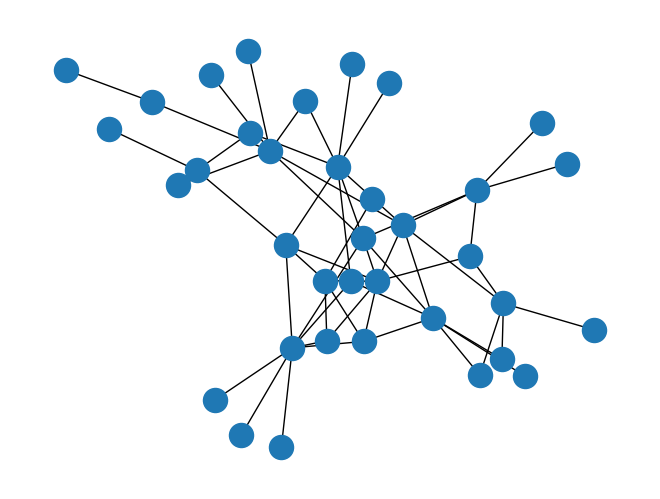

In [8]:
import networkx as nx

graph1 = nx.Graph()
graph1.add_nodes_from(nodes_list)
graph1.add_edges_from(edges_list)
  
nx.draw(graph1)

In [ ]:
# nx.write_gexf(graph1, "network.gexf")
